In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path

import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !twix-pip install gluonts==0.8.1
# !twix-pip install pytorchts==0.5.10

In [5]:
from data_utils import load_features_and_targets
from training_utils import dataset_metadata

In [6]:
features_per_day, targets_per_day = load_features_and_targets('/home/ayagudin/dl/probabilistic-time-series/lobster-preprocessed-dataset/')

# Cut session begin & end
> TODO reconstruct dataset so that it will have only moments with huge traded_amount

In [7]:
timestamps_to_cut = 200

In [8]:
for day in features_per_day:
    features_per_day[day] = features_per_day[day][timestamps_to_cut:-timestamps_to_cut]
    targets_per_day[day] = targets_per_day[day][timestamps_to_cut:-timestamps_to_cut].reshape(-1, 1)

In [9]:
full_features = np.concatenate(list(features_per_day.values()))
full_targets = np.concatenate(list(targets_per_day.values()))
full_features.shape, full_targets.shape

((926340, 27), (926340, 1))

# Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

In [12]:
feature_scaler.fit(full_features)
target_scaler.fit(full_targets)

StandardScaler()

In [13]:
for day in features_per_day:
    features_per_day[day] = feature_scaler.transform(features_per_day[day])
    targets_per_day[day] = target_scaler.transform(targets_per_day[day]).reshape(-1)

# Defining dataset

In [16]:
days = sorted(list(features_per_day.keys()))
train_days = days[:10]
val_days = days[10:15]
test_days = days[15:20]
print(len(train_days), len(val_days), len(test_days))

10 5 5


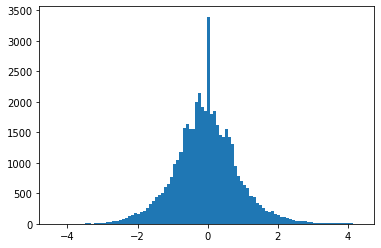

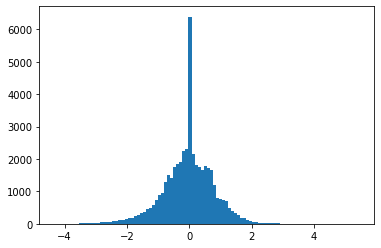

In [17]:
plt.hist(targets_per_day[days[-1]], bins=100);
plt.show()
plt.hist(targets_per_day[days[0]], bins=100);
plt.show()

In [18]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [20]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day][None],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day].T
        }
        for day in train_days
    ],
    freq=dataset_metadata['freq'],
    one_dim_target=False
)

val_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day][None],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day].T
        }
        for day in val_days
    ],
    freq=dataset_metadata['freq'],
    one_dim_target=False
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: targets_per_day[day][None],
            FieldName.START: dataset_metadata['start'],
            FieldName.FEAT_DYNAMIC_REAL: features_per_day[day].T
        }
        for day in test_days
    ],
    freq=dataset_metadata['freq'],
    one_dim_target=False
)

# for validation we have to create a list of dicts 
# with all suffixes from test_days

In [21]:
targets_per_day[train_days[0]][None].shape,  features_per_day[train_days[0]].T.shape

((1, 46317), (27, 46317))

# Load some model

In [38]:
from gluonts.model.predictor import Predictor
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.evaluation import make_evaluation_predictions

from training_utils import get_rolled_dataset

In [39]:
predictor = PyTorchPredictor.deserialize(Path('./checkpoints/simple_feedforward'))

In [87]:
def get_dataset_prediction_stats(predictor, dataset):
    dataset_rolled = get_rolled_dataset(dataset, 
                                     context_length=5,
                                     prediction_length=1, max_size=np.inf)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_rolled, predictor=predictor, num_samples=10
    )
    forecasts, tss = list(tqdm(forecast_it)), list(tqdm(ts_it))
    targets = np.array([ts.iloc[0].values.item() for ts in tss])
    
    forecasts = np.array([forecast.samples for forecast in forecasts]).squeeze()
    print('forecasts shape:', forecasts.shape)
    mean = forecasts.mean(1)
    var = forecasts.var(1)
    return mean, var, targets

test_mean, test_var, test_targets = get_dataset_prediction_stats(predictor, test_ds)

5it [00:06,  1.25s/it]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

forecasts shape: (231555, 10, 1)


In [98]:
train_mean, train_var, train_targets = get_dataset_prediction_stats(predictor, train_ds)

10it [00:08,  1.16it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

forecasts shape: (463110, 10, 1)


In [97]:
val_mean, val_var, val_targets = get_dataset_prediction_stats(predictor, val_ds)

5it [00:04,  1.15it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

forecasts shape: (231555, 10, 1)


In [111]:
np.save('prediction-stats/mean_val.npy', val_mean.squeeze())
np.save('prediction-stats/var_val.npy', val_var.squeeze())
np.save('prediction-stats/targets_val.npy', np.array(val_targets))
np.save('prediction-stats/mean_test.npy', test_mean.squeeze())
np.save('prediction-stats/var_test.npy', test_var.squeeze())
np.save('prediction-stats/targets_test.npy', np.array(test_targets))

# Recalibration metrics

In [130]:
RESULTS_DIRECTORY = '/home/ayagudin/dl/probabilistic-time-series/point-calibration/results/'

In [153]:
stats = pd.read_csv(RESULTS_DIRECTORY + 'nasdaq_mid_dataset.csv')

In [154]:
stats[stats.columns[:13]]

,dataset,rmse,loss,ece,threshold_calibration_error_less,threshold_calibration_error_greater,threshold_calibration_error_both,threshold_calibration_error_all,point_calibration_error,distribution_calibration_error,point_calibration_error_uniform_mass,val_point_calibration_error,val_point_calibration_error_uniform_mass
0,nasdaq,0,gaussian_nll,0.01628,0.098401,0.093484,0.191885,0.180900,0.115948,0,0.057747,0.096026,0.104429
1,nasdaq,0,gaussian_nll,0.01628,0.098625,0.093386,0.192012,0.178188,0.126721,0,0.050856,0.000000,0.000000
2,nasdaq,0,gaussian_nll,0.07951,0.105339,0.112687,0.218026,0.226221,0.139713,0,0.088234,0.000000,0.000000


In [155]:
stats[stats.columns[13:]]

,train_point_calibration_error,train_point_calibration_error_uniform_mass,train_true_vs_pred_loss,true_vs_pred_loss,decision_loss,posthoc_recalibration,train_frac,seed,num_layers,n_dim,epochs,n_bins,flow_type
0,0.116226,0.091369,0.184625,0.064209,0.247083,iterative_point,1.0,0,0,NaN,NaN,141.0,NaN
1,0.000000,0.000000,0.000000,0.064209,0.247083,NaN,1.0,0,0,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.360793,0.282885,average,1.0,0,0,NaN,NaN,NaN,NaN


# Metrics [TODO]

In [62]:
from gluonts.evaluation import Evaluator

In [ ]:
# actually we can easily calculate it by hand
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), 
                                      iter(forecasts), 
                                      num_series=len(test_ds_rolled))

Running evaluation:   0%|                                                     | 0/1206 [00:00<?, ?it/s]

In [67]:
# print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
agg_metrics

{'MSE': 6.7899866179483634,
 'abs_error': 2443.6014391388744,
 'abs_target_sum': 2401.5612582004396,
 'abs_target_mean': 1.9913443268660362,
 'seasonal_error': 0.3556682882123128,
 'MASE': inf,
 'MAPE': 1.3371886375536262,
 'sMAPE': 1.715921922018875,
 'MSIS': inf,
 'QuantileLoss[0.1]': 1640.415236374736,
 'Coverage[0.1]': 0.29933665008291876,
 'QuantileLoss[0.5]': 2443.6014391388744,
 'Coverage[0.5]': 0.4187396351575456,
 'QuantileLoss[0.9]': 1912.8786718323827,
 'Coverage[0.9]': 0.5895522388059702,
 'RMSE': 2.6057602763777723,
 'NRMSE': 1.3085432997309407,
 'ND': 1.0175053544001358,
 'wQuantileLoss[0.1]': 0.6830620000940335,
 'wQuantileLoss[0.5]': 1.0175053544001358,
 'wQuantileLoss[0.9]': 0.796514627849118,
 'mean_absolute_QuantileLoss': 1998.9651157819978,
 'mean_wQuantileLoss': 0.8323606607810957,
 'MAE_Coverage': 0.19701492537313434,
 'OWA': nan}

In [68]:
# print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
agg_metrics

{'MSE': 6.7899866179483634,
 'abs_error': 2443.6014391388744,
 'abs_target_sum': 2401.5612582004396,
 'abs_target_mean': 1.9913443268660362,
 'seasonal_error': 0.3556682882123128,
 'MASE': inf,
 'MAPE': 1.3371886375536262,
 'sMAPE': 1.715921922018875,
 'MSIS': inf,
 'QuantileLoss[0.1]': 1640.415236374736,
 'Coverage[0.1]': 0.29933665008291876,
 'QuantileLoss[0.5]': 2443.6014391388744,
 'Coverage[0.5]': 0.4187396351575456,
 'QuantileLoss[0.9]': 1912.8786718323827,
 'Coverage[0.9]': 0.5895522388059702,
 'RMSE': 2.6057602763777723,
 'NRMSE': 1.3085432997309407,
 'ND': 1.0175053544001358,
 'wQuantileLoss[0.1]': 0.6830620000940335,
 'wQuantileLoss[0.5]': 1.0175053544001358,
 'wQuantileLoss[0.9]': 0.796514627849118,
 'mean_absolute_QuantileLoss': 1998.9651157819978,
 'mean_wQuantileLoss': 0.8323606607810957,
 'MAE_Coverage': 0.19701492537313434,
 'OWA': nan}

In [82]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,36.260365,6.483162,5.293073,5.293073,0.672751,9.636793,1.224839,2.0,331.964121,1.296632,0.0,6.483162,0.0,10.008278,0.0
1,NaN,22.679234,5.471787,4.615551,4.615551,0.477129,11.468163,1.185511,2.0,342.736380,1.094357,0.0,5.471787,0.0,7.294961,0.0
2,NaN,19.992542,4.768174,4.324502,4.324502,0.677522,7.037664,1.102595,2.0,247.329103,0.953635,0.0,4.768174,0.0,7.513974,0.0
3,NaN,23.797688,4.980725,4.415156,4.415156,0.291049,17.113039,1.128097,2.0,657.068750,0.996145,0.0,4.980725,0.0,8.596531,0.0
4,NaN,22.288261,5.172645,4.119337,4.119337,0.090654,57.058969,1.255698,2.0,1893.796545,1.034529,0.0,5.172645,0.0,7.684998,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,NaN,1.055888,2.012027,1.075258,1.075258,0.338761,5.939369,1.871203,2.0,10.901397,0.402405,0.0,2.012027,0.0,0.077582,0.0
1202,NaN,2.656239,2.188793,1.876834,1.876834,0.424644,5.154416,1.166216,2.0,103.498513,0.437759,0.0,2.188793,0.0,1.927442,0.0
1203,NaN,4.899818,2.767113,1.533302,1.533302,0.801576,3.452093,1.804676,2.0,84.217684,0.553423,0.0,2.767113,0.0,2.987987,0.0
1204,NaN,5.060603,2.859463,1.571472,1.571472,0.343532,8.323706,1.819608,2.0,194.472268,0.571893,0.0,2.859463,0.0,2.951449,0.0


In [69]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,22.008644,4.869616,4.415156,4.415156,0.529613,9.194677,1.102932,2.000000,286.597556,1.134803,0.0,4.869616,0.0,6.795611,0.0
1,NaN,17.311729,4.091903,4.119337,4.119337,0.384088,10.653544,0.993340,1.973537,324.954032,0.961690,0.0,4.091903,0.0,6.358344,0.0
2,NaN,30.518023,5.835865,5.751116,5.751116,0.338761,17.227082,1.014736,2.000000,295.596196,1.344757,0.0,5.835865,0.0,8.514152,0.0
3,NaN,23.523882,5.026651,4.706205,4.706205,0.577325,8.706792,1.068090,2.000000,248.171312,1.159536,0.0,5.026651,0.0,7.376008,0.0
4,NaN,19.869068,3.950956,3.637437,3.637437,0.765791,5.159315,1.086192,2.000000,166.972028,1.354496,0.0,3.950956,0.0,5.869420,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,NaN,3.108257,1.931677,1.571472,1.571472,0.477128,4.048547,1.229215,2.000000,45.549187,0.609762,0.0,1.931677,0.0,1.368648,0.0
1202,NaN,7.142027,2.806405,2.382590,2.382590,0.401981,6.981444,1.177880,2.000000,102.695818,0.677876,0.0,2.806405,0.0,3.324632,0.0
1203,NaN,4.629624,2.436457,1.676440,1.676440,0.498599,4.886605,1.453351,2.000000,61.318851,0.686437,0.0,2.436457,0.0,1.515742,0.0
1204,NaN,2.816041,1.502892,1.733696,1.733696,0.474743,3.165697,0.866872,1.530051,43.893115,0.533668,0.0,1.502892,0.0,1.616239,0.0


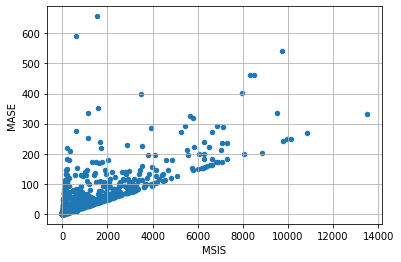

In [83]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()